In [ ]:
BSM Time Machine
Theta Machine

In [2]:
import matplotlib.pyplot as plt
import pandas_market_calendars as pmc
%matplotlib inline
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
pd.set_option("display.max_rows", 50, "display.max_columns", 10)
import random
import warnings
import time
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [18]:
# load the dataframe with 11 year SPX 1 Day OHLC data and other custom columns based around those OHLC data
df = pd.read_pickle('../../dfs/1day_spx_max_iv_rth.pkl')
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3965 entries, 144 to 4114
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            3965 non-null   object 
 1   open            3965 non-null   float64
 2   high            3965 non-null   float64
 3   low             3965 non-null   float64
 4   close           3965 non-null   float64
 5   iv_open         3965 non-null   float64
 6   iv_high         3965 non-null   float64
 7   iv_low          3965 non-null   float64
 8   iv_close        3965 non-null   float64
 9   prev_close      3965 non-null   float64
 10  iv_prev_close   3965 non-null   float64
 11  open_close      3965 non-null   float64
 12  close_close     3965 non-null   float64
 13  close_open      3965 non-null   float64
 14  iv_open_close   3965 non-null   float64
 15  iv_close_close  3965 non-null   float64
 16  iv_close_open   3965 non-null   float64
 17  real_vol        3965 non-null  

In [4]:
def get_subset(start=None, end=None, df=df, lookback=0, hp=0):
    # * lookback and hp are here so that this subset filtering can be performed *before* calculating BSM prices
    #   for performance reasons. By adding hp to the end and subtracting lookback from the beginning, shifts
    #   in later functions can be performed and the beginning and end of the subset aren't NaN due to shifting
    #   out of range of the df. Later trimming will remove rows to get back to the intended subset.
    # NOTE: `None` works as valid indexes and df[None:None] returns the entire df
    lookback = timedelta(days=lookback)
    hp = timedelta(days=hp)
    if start is not None:
        start = datetime.strptime(start, '%Y-%m-%d').date() - lookback
        start = df[df['date'] >= start].index[0]
    if end is not None:
        end = datetime.strptime(end, '%Y-%m-%d').date() + hp
        end = df[df['date'] <= end].index[-1] + 1  # +1 to include the last entry.
    return df[start:end].copy()

In [5]:
def kelly(p: float, b: float):
    # the kelly criterion for wagering
    # p: probability of win
    # b: net payout for a win
    return p + (p - 1) / b

def scale_b(b: float, c: float):
    # * the kelly criterion expects max loss of 1.0
    #   so scale the winners and losers accordingly.
    return b / abs(c)

In [6]:
# print and plot the data for quick validation that the data appear intact and as expected.
print(f"mean real_vol:           {df['real_vol'].mean():.2f}%")
print(f"max real_vol:            {df['real_vol'].max():.2f}%")
print(f"median real_vol:         {df['real_vol'].median():.2f}%")
print(f"median daily movement:   {100 * df['open_close'].abs().median():.3f}%")
print(f"mean close_open:         {100 * df['close_open'].abs().mean():.3f}%")
print(f"median close_open:       {100 * df['close_open'].abs().median():.3f}%")
print(f"iv open mean:            {100 * df['iv_open'].mean():.2f}%")
print(f"iv open median:          {100 * df['iv_open'].median():.2f}%")

# df.plot('date', 'open')
# df.plot('date', 'iv_open')
# df.plot('date', 'close_open')
# df.plot('date', 'iv_close_close')
# df.plot('date', 'real_vol')
# df.plot('date', 'max_vol')

mean real_vol:           2.14%
max real_vol:            26.77%
median real_vol:         1.36%
median daily movement:   0.433%
mean close_open:         0.270%
median close_open:       0.134%
iv open mean:            19.84%
iv open median:          17.23%


<AxesSubplot:xlabel='date'>

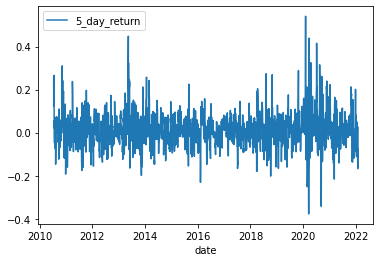

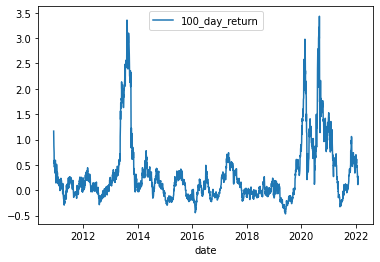

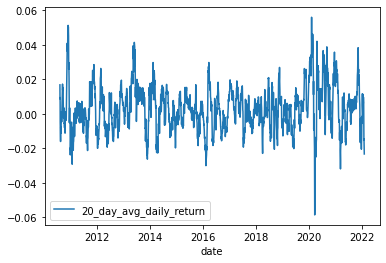

In [1903]:
# shift(1) is to prevent look-ahead bias
df['1_day_return'] = (df['close'].shift(1) - df['open'].shift(2)) / df['open'].shift(2)
df['20_day_avg_daily_return'] = df['1_day_return'].shift(1).rolling(20).mean()
df['5_day_return'] = (df['close'].shift(1) - df['open'].shift(5)) / df['open'].shift(5)
df['10_day_return'] = (df['close'].shift(1) - df['open'].shift(10)) / df['open'].shift(10)
df['15_day_return'] = (df['close'].shift(1) - df['open'].shift(15)) / df['open'].shift(15)
df['20_day_return'] = (df['close'].shift(1) - df['open'].shift(20)) / df['open'].shift(20)
df['50_day_return'] = (df['close'].shift(1) - df['open'].shift(50)) / df['open'].shift(50)
df['100_day_return'] = (df['close'].shift(1) - df['open'].shift(100)) / df['open'].shift(100)
df.plot('date', '5_day_return')
df.plot('date', '100_day_return')
df.plot('date', '20_day_avg_daily_return')

In [1782]:
print(df['iv_open'].mean())

0.19840027742749056


plotting...
rr mean: 15.50% | rr median: 9.44%


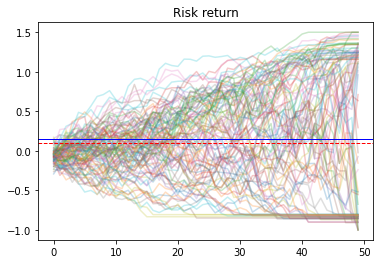

PoM mean: 24.50% | PoM median: 7.35%


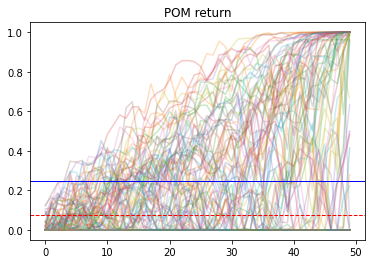

          date      coef  risk_return        pvo  iv_open
42  2018-07-26  1.002773     1.216443  17.139935   0.1245
43  2018-10-08  1.003575    -0.832788  17.351022   0.1605
44  2019-02-01  1.003704     1.156183  17.620285   0.1663
45  2019-04-24  1.002791    -0.814227  17.581501   0.1253
46  2019-07-08  1.003058    -0.565001  17.379900   0.1373
47  2019-09-20  1.003105     1.194024  17.315560   0.1394
48  2019-12-04  1.003648     1.156086  17.621078   0.1638
49  2021-04-08  1.003768     1.112739  17.983589   0.1692
50  2021-06-23  1.003619     1.112522  17.985444   0.1625
51  2021-10-15  1.003706     1.109843  18.008340   0.1664
REPORT FOR CALL DEBIT SPREAD:
-------------------------------------

1.3% of days meet criteria (52)
hp = 50 trading (~70 calendar) days
-------------------------------------
median spot movement:         3.62%
mean spot movement:           4.32%
-------------------------------------
probability of a win:         57.69%
payout for winners:           116.16%
lo

In [34]:
"""<---   begin tunable parameters   --->"""
"""======================================"""
# Underlying-specific parameters:
# below is for SPX. For SPY, for example, min_tick = 0.01, spread_loss = 0.01, min_risk = 0.05
spread_loss = 0.05         # bid-ask spread losses on a trade. Quoted as a % of opening position value
min_tick = 0.05            # [CONSTANT] the minimum spread tick for SPX options is $0.05; add to all long legs.
min_risk = 0.02            # [CONSTANT] spot movement in % beyond 2 SD (for unhedged positions) in fudge_factor()
min_strike_gap = 5         # [CONSTANT] minimum strike width of SPX options is 5

# Position parameters:
is_credit = False          # False for DEBIT (long), True for CEDIT (short)
is_hedged = True          # no hedging positions. naked short if credit else long only for debit
tenor = 50                 # trading days until expiry, not calendar days
hp = 50                    # holding period, inclusive of opening day 0 and closing day. hp=0 is o-c same-day
stop_loss = -0.8           # risk return threshold to close a position below.
scalping = True               # close a position upon reaching a defined level of profit
pom_threshold = None       # Percent of Max possible return scalping threshold, supercedes
rr_threshold = 1.5        # Risk Return threshold to close the position upon reaching
sequential = True          # simulates a real environment where only 1 position will be open at a time
r = 0.01                   # [CONSTANT] risk-free rate for BSM calculations
days = {0, 1, 2, 3, 4}     # for filtering the opening trading day of the week. 0 = Mon, 4 = Fri

# Optionally test on a subset of dates:
full_df = True             # supersedes start, end, AND training set. Will use entire df.
training_set = True        # supersedes start, end. automatically trains on past 11 years
# start = '2020-03-27'       # [optional] 'YYYY-MM-DD' format date. used to narrow the DF to a specific range
# end = '2022-03-01'         # [optional] end date for the narrowing range
# start, end = '2008-01-01', '2009-01-01'  # bear run
# start, end = '2020-03-27', '2021-08-27'  # bull run

# call parameters:
call_coef = '0.05 SD'       # relative distance OTM for strike. 'x' for constant multiplier, 'SD' for std dev.
call_gap = 40              # call strike gap; distance between long and short call strikes
call_inside = False        # True: force hedging strikes to be inside of coef. False: allow hedges further OTM
# TODO: for optimization loop, omit the inside flag since it's redundant if you're trying all combinations.

# put parameters:
put_coef = ''        # relative distance OTM for strike. 'x' for constant multiplier, 'SD' for std dev.
put_gap = 50               # put strike gap; distance between long and short put strikes
put_inside = False         # force the furthest OTM strike (either long or short) is no further than coef OTM

# Parameters for filtering realized volatility
vol_threshold = 2.0          # threshold value for realized volatility, combines with the below two filters.
lookback = 3               # trading days for the rolling realized volatility lookbacks
vol_greater_than = True    # False changes the direction to real_vol.rolling() (<) vol_threshold from (>)
use_max = True             # use max_vol (high-low) or real_vol (open-close)

# Parameters for filtering implied volatility
iv_min_threshold = 0.23    # lower bound for iv open
iv_max_threshold = 0.17    # upper bound for iv open
iv_greater_than = False     # if False, no MIN iv filtering will happen
iv_less_than = True       # if False, no MAX iv filtering will happen

# Misc. parameters:
sample = False             # Random sample valid rows. 0 < sample < 1: % of df. sample > 1: n=sample.
return_only = False        # just return the output instead of printing or plotting the data.
lrr_only = False           # return only (lrr, num_winners) from passthrough()
plot = True                # plot position performance (PoM and RR over HP + histograms for both)
analyze = False            # run the linear regression and scatter plot analysis (analyze_results())
silently = True            # used by find_max_losers() and get_true_lrr()
return_tally = True        # used by find_max_losers()
"""======================================"""
"""<---    end tunable parameters    --->"""

if training_set:
    # disregard above values for start and end,
    # force the testing to be on the following days:
    start, end = '2006-01-01', '2018-01-01'
if full_df:
    # supercedes training_set and any start or end
    # from above, forcing the entire df to be used.
    start, end = None, None
hp = min(hp, tenor)  # force hp <= tenor
if not put_coef:
    put_gap = 0
if not call_coef:
    call_gap = 0

output = passthrough(spread_loss, min_tick, min_risk, min_strike_gap, is_credit, is_hedged, tenor, hp,
                     call_coef=call_coef, call_gap=call_gap, call_inside=call_inside, put_coef=put_coef,
                     put_gap=put_gap, put_inside=put_inside, stop_loss=stop_loss, scalping=scalping,
                     pom_threshold=pom_threshold, rr_threshold=rr_threshold, sequential=sequential,
                     r=r, days=days, start=start, end=end, vol_threshold=vol_threshold, lookback=lookback,
                     vol_greater_than=vol_greater_than, use_max=use_max, iv_min_threshold=iv_min_threshold,
                     iv_max_threshold=iv_max_threshold, iv_greater_than=iv_greater_than,
                     iv_less_than=iv_less_than, sample=sample, return_only=return_only, lrr_only=lrr_only,
                     plot=plot)

lrr = output[0]
num_valid_days = output[1]
num_winners = output[2]
p = output[3]
b = output[4]
c = output[5]
pdf = output[6]
expected_return = output[7]
wager = output[8]
subset_size = output[9]

mean_move = pdf['spot_movement'].abs().mean()          # median is more useful than mean.    
median_move = pdf['spot_movement'].abs().median()      # median is more useful than mean.

# print(pdf.iloc[:10][['date', 'pvo', 'pvc', 'coef', 'true_return',
#                      'pom_return', 'risk_return']])  # DAT

# plt.hist(pdf['spot_movement'], bins=len(pdf)//2 + 5, histtype='stepfilled')
# plt.axvline(mean_move, color='k', linestyle='dashed', linewidth=1)
# plt.axvline(median_move, color='r', linestyle='solid', linewidth=1)
# plt.show()

print(pdf.iloc[-10:][['date', 'coef', 'risk_return', 'pvo', 'iv_open']])

if analyze:
    analyze_results(pdf)

strat_name = get_strat_name(is_credit, call_coef, put_coef)
max_consecutive_days = find_max_losers(pdf, silently=silently, return_tally=return_tally)
# consecutive_failures = get_consecutive_failures(max_consecutive_days, duration, sequential=sequential)
# true_lrr, bsm_lrr = get_true_lrr(pdf, wager, b, sequential=sequential, silently=silently)

print('=====================================')
print(f"REPORT FOR {strat_name.upper()}:")
print('-------------------------------------')
# print(consecutive_failures)
print(f'\n{100*num_valid_days/(subset_size - hp - lookback):.1f}% of days meet criteria ({num_valid_days})')
print(f'hp = {hp} trading (~{round(7/5*hp)} calendar) days')
print('-------------------------------------')
print(f"median spot movement:         {100 * median_move:.2f}%")
print(f"mean spot movement:           {100 * mean_move:.2f}%")
print('-------------------------------------')
print(f"probability of a win:         {100 * p:.2f}%")
print(f"payout for winners:           {100 * b:.2f}%")
print(f"loss for losers:              {100 * c:.2f}%")
print(f'expected_return:              {100 * expected_return:.2f}%')
print(f'wager:                        {100 * wager:.2f}%')
print(f'wager expected_return:        {100 * wager * expected_return:.2f}%')
print(f'average expected lrr:         {100 * lrr:,.0f}%')
# print('-------------------------------------')
# print(f'true computed lrr:            {100 * true_lrr:,.0f}%')
# print(f'computed bsm lrr:             {100 * bsm_lrr:,.0f}%')
# print(f'$100,000 at true lrr:        ${100000 * (1 + true_lrr):,.0f}')
print('-------------------------------------')
print(f"mean iv open:                 {100 * pdf['iv_open'].mean():.2f}")
print(f"median iv open:               {100 * pdf['iv_open'].median():.2f}")
print('-------------------------------------')
print(f"cumulative risk return:       {100 * pdf['risk_return'].sum():.2f}%")
print(f"highest risk return:          {100 * pdf['risk_return'].max():.2f}%")
print(f"mean risk return:             {100 * pdf['risk_return'].mean():.2f}%")  # !NOTE: this == expected_return!
print(f"median risk return:           {100 * pdf['risk_return'].median():.2f}%")
print('=====================================')

In [8]:
def passthrough(spread_loss, min_tick, min_risk, min_strike_gap, is_credit, is_hedged, tenor, hp,
                call_coef, call_gap, call_inside, put_coef, put_gap, put_inside, stop_loss=-1, scalping=False,
                pom_threshold=None, rr_threshold=None, sequential=True, r=0.01, days={0,1,2,3,4},
                start=None, end=None, vol_threshold=0.0, lookback=1, vol_greater_than=True,
                use_max=True, iv_min_threshold=0.10, iv_max_threshold=0.40, iv_greater_than=False,
                iv_less_than=False, sample=False, return_only=True, lrr_only=True,plot=False):
    df = get_subset(start, end, hp=hp, lookback=lookback)  # copy of df, narrowed down for a specific time period
    subset_size = len(df)  # used in calculations later
    df = get_strikes(df, 'C', is_credit, is_hedged, call_inside, call_coef, call_gap, hp)   # add call strikes
    df = get_strikes(df, 'P', is_credit, is_hedged, put_inside, put_coef, put_gap, hp)      # add put strikes
    a, df = calc_bsm_prices(df, tenor, hp, min_risk, r, put=bool(put_coef), call=bool(call_coef))  # BSM over hp
#     plot_positions(a, show=100, all=False, pom=True, risk=True)  # DAT

    # all shift(s) must be before filtering so they don't skip days that are filtered out and get messed up
    if use_max:
        df['rolling_vol'] = df['max_vol'].shift(1).rolling(lookback).mean()
    else:
        df['rolling_vol'] = df['max_vol'].shift(1).rolling(lookback).mean()
    df['spot_movement'] = (df['close'].shift(-hp) - df['open']) / df['open']  # spot movement over the hp
    df = clean_rows(df, lookback, hp)  # all shifts have been performed; clear out NaN rows.

    # filter the df to meet specific parameters:
    df = df[df['day'].isin(days)]  # narrow down the days
    df = filter_iv(df, iv_greater_than, iv_min_threshold, iv_less_than, iv_max_threshold)
    df = filter_vol(df, vol_greater_than, vol_threshold)

    if sequential:
        df = filter_sequential(df, hp)
        valid_days, num_winners = get_valid_days(df)
        max_potential_days = subset_size // hp  # used as denominator for % days valid post-sequential filter
    else:
        valid_days, num_winners = get_valid_days(df)
        if sample:
            # sample is mutually exclusive with sequential.
            df = sample_df(df, sample)  # optionally limit the rows to a random sample

    # only calculate LRR on sequential
    p, b, c = calc_pbc(df)
 
    expected_return = p * b - (1 - p) * abs(c)
    if expected_return <= 0:
        wager = 0
    else:
        wager = kelly(p, scale_b(b, c))
#         if not is_hedged:
#             wager = kelly(p, scale_b(b, c))
#         else:
#             wager = kelly(p, b)
    lrr = (1 + wager * expected_return)**num_winners - 1
    if lrr_only:
        return lrr, num_winners
    df.reset_index(inplace=True, drop=True)

    if not return_only:
#         print_df(df, is_credit)
        if plot:
            # TODO: change these arguments to be parameters.
            # TODO: filter pom and risk based on if they apply, eg. long-only positions have no PoM.
            plot_positions(a, show=100, all=False, pom=True, risk=True)
    return (lrr, valid_days, num_winners, p, b, c, df, expected_return, wager, subset_size)

In [9]:
def analyze_results(df):
    y = df['risk_return']  # the y axis is returns
    subjects = df[['iv_open', 'rolling_vol', 'previous_vol', 'close_open',
                   '1_day_return', '20_day_avg_daily_return', '5_day_return',
                   '10_day_return', '20_day_return', '50_day_return',
                   '100_day_return', 'day']]
    for subject in subjects:
        # * calculate some regressions and plot
        #   scatterplots with regression imbedded
        x = df[subject]
        try:
            m, b = np.polyfit(x, y, 1)
        except np.linalg.LinAlgError:
            continue
        yp = np.polyval([m, b], x)
        plt.plot(x, yp)
        plt.scatter(x,y)
        plt.title(f'risk_return vs {subject}')
        plt.show()

In [10]:
def calc_pbc(df):
    # p: probability of a win
    # b: payout for a win
    # c: capital loss in the event of a loss (essentially `b` for losses)
    if df[df['risk_return'] >= 0].count()[0] == 0:
        p, b = 0, 0
    else:
        p = df[df['risk_return'] >= 0].count()[0] / len(df)  # df is filtered for valid days, so use its entirety
        b = df[df['risk_return'] >= 0]['risk_return'].mean()
    if df[df['risk_return'] < 0].count()[0] == 0:
        # No losers found, return 0 since mean of empty sequence will return nan
        return p, b, 0
    c = df[df['risk_return'] < 0]['risk_return'].mean()   # mean payout for losers
    d = df[df['risk_return'] < 0]['risk_return'].median()   # median payout for losers
    return p, b, min(c, d)

In [11]:
def clean_rows(df, lookback, hp):
    if hp > 0:
        # ignore the first and last few rows that will be NaN due to shift()s above
        df = df[lookback:-hp+1]  # +1 to include the last valid entry (equivalent to [start:-(hp-1)])
    else:
        # just ignore the first rows
        df = df[start:]
    return df

In [12]:
def filter_iv(df, iv_greater_than, iv_min_threshold, iv_less_than, iv_max_threshold):
    if iv_greater_than:
        df = df[df['iv_open'] >= iv_min_threshold]
    if iv_less_than:
        df = df[df['iv_open'] <= iv_max_threshold]
    return df

In [13]:
def filter_vol(df, vol_greater_than, vol_threshold):
    if vol_greater_than:
        df = df[df['rolling_vol'] > vol_threshold]
    else:
        df = df[df['rolling_vol'] < vol_threshold]
    return df

In [14]:
def filter_sequential(df, hp):
    # * limit 1 open position at a time, simulating real trading
    #   where trades are sequential and non-concurrent
    df['idx'] = df.index
    next_valid = -1  # initial value so the below condition runs the first time
    for index in df.copy()['idx']:
        if index > next_valid:
            df.at[index, 'valid'] = True
            next_valid = index + hp
    return df[df['valid'] == True]

In [15]:
def get_valid_days(df):
    valid_days = len(df)  # must happen after all filtering but before sequential or sample.
    winners = df[df['risk_return'] > 0].count()[0]   # TODO: this is just a thought, not final...
#     win = winners / valid_days
    return valid_days, winners

In [16]:
def calc_bsm_prices(df, tenor, hp, min_risk: float, r, call: bool, put: bool):
    a = np.ones((df.shape[0], 25, hp))  # create a blank 3D array with 25 columns
    zeros = np.zeros(a.shape[0])  # create an array of zeros of shape a.shape[0] for when k is NaN downstream
    for i in range(0, hp):
        # send a copy of the df otherwise the original would be modified each loop, causing issues.
        shifted_a = perform_shifts(df.copy(), i, tenor)  # shift: spot, iv, tenor by i.
        # compute the bsm prices and append the array to a new plane in axis 2 (dimension 3):
        a[:,:,i] = compute_bsm(shifted_a, r, call, put, zeros)
    a = np.nan_to_num(a)  # clear out NaN values and set them to 0
    df['pvo'] = a[:, 10, 0]   # position value open (net opening credit for credits, net debit for debits)
    df['pvc'] = a[:, 11, -1]  # position_value_close (net closing debit for credits, net credit for debits)

    a = add_returns(a, is_credit, is_hedged, hp, spread_loss, call, call_gap, put, put_gap, min_risk)

    if scalping or stop_loss:
        a = scalp_stoploss(a, scalping, stop_loss, rr_threshold, pom_threshold)

    open_max = np.amax(a[:, 10, :], axis=1)   # the highest net position value at a market open over the hp
    close_max = np.amax(a[:, 11, :], axis=1)  # the highest net position value at a market close over the hp
    open_min = np.amin(a[:, 10, :], axis=1)   # the lowest net position value at a market open over the hp
    close_min = np.amin(a[:, 11, :], axis=1)  # the lowest net position value at a market close over the hp

    df['pos_max'] = np.maximum(open_max, close_max)  # MAX position value (open, close) over the hp
    df['pos_min'] = np.minimum(open_min, close_min)  # MIN position value (open, close) over the hp

#     df['lco'] = a[:, 12, 0]         # long call open
#     df['sco'] = a[:, 13, 0]         # short call open
#     df['lpo'] = a[:, 14, 0]         # long put open
#     df['spo'] = a[:, 15, 0]         # short put open
#     df['lcc'] = a[:, 16, -1]        # long call close
#     df['scc'] = a[:, 17, -1]        # short call close
#     df['lpc'] = a[:, 18, -1]        # long put close
#     df['spc'] = a[:, 19, -1]        # short put close
    df['spot_open'] = a[:, 0, 0]    # spot price at the time the position was opened
    df['spot_close'] = a[:, 1, -1]  # spot price at the time the position was closed [hp] trading days after open
    # calculate the closing intrinsic values:
#     df['lci'] = np.maximum(0, df['spot_close'] - df['long_call_k'])   # long call intrinsic at close
#     df['sci'] = np.maximum(0, df['spot_close'] - df['short_call_k'])  # short call intrinsic at close
#     df['lpi'] = np.maximum(0, df['long_put_k'] - df['spot_close'])    # long put intrinsic at close
#     df['spi'] = np.maximum(0, df['short_put_k'] - df['spot_close'])   # short put intrinsic at close
    df['risk_return'] = a[:, 23, -1]
    df['pom_return'] = a[:, 24, -1]
    df['winner'] = df['risk_return'] >= 0  # (bool), used by later functions.

    return a, df  # return a so it can be optionally plotted and df for further analysis

In [17]:
def perform_shifts(df, i, tenor):
    df['open'] = df['open'].shift(-i)
    df['close'] = df['close'].shift(-i)
    df['iv_open'] = df['iv_open'].shift(-i)
    df['iv_close'] = df['iv_close'].shift(-i)
    a = df[['open', 'close', 'iv_open', 'iv_close', 'long_call_k',
            'short_call_k', 'long_put_k', 'short_put_k']].to_numpy()
    a = np.hstack((a, np.ones((a.shape[0], 17))))  # add placeholder columns for BSM values
    a[:, 8] = (tenor - i)      # quoted in days, will be adjusted downstream
    a[:, 9] = (tenor - i - 1)  # quoted in days, will be adjusted downstream
    return a

In [18]:
def scalp_stoploss(a, scalping, stop_loss, rr_threshold, pom_threshold):
    if stop_loss:
        indices = np.argmax(a[:, 23, :] <= stop_loss, axis=1)
        for row, i in enumerate(indices):
            if i == 0:
                # the threshold was never reached
                continue
            a[row, 24, i:] = a[row, 24, i]        # freeze the PoM return at the time of scalp
            a[row, 23, i:] = a[row, 23, i]        # freeze the risk return at the time of scalp
    if not scalping:
        # prevent the rest from executing
        return a
    if pom_threshold:
        indices = np.argmax(a[:, 24, :] > pom_threshold, axis=1)
        for row, i in enumerate(indices):
            if i == 0:
                # the threshold was never reached
                continue
            a[row, 24, i:] = pom_threshold
            a[row, 23, i:] = a[row, 23, i]
#         a[:, 24, indices:] = pom_threshold       # freeze the PoM return at the time of scalp
#         a[:, 23, indices:] = a[:, 23, indices]  # freeze the risk return at the time of scalp
    else:
#         # scalp on risk return
        indices = np.argmax(a[:, 23, :] > rr_threshold, axis=1)
        for row, i in enumerate(indices):
            if i == 0:
                # the threshold was never reached
                continue
            a[row, 24, i:] = a[row, 24, i]        # freeze the PoM return at the time of scalp
            a[row, 23, i:] = rr_threshold         # freeze the risk return at the time of scalp
    return a

In [19]:
def add_returns(a: np.ndarray, is_credit: bool, is_hedged: bool, hp: int,
                spread_loss: float, call: bool, call_gap: int, put: bool,
                put_gap: int, min_risk: float):
    if is_hedged:
        # overall position risk is equal to the greatest risk leg.
        strike_gap = max(call * call_gap, put * put_gap)
    else:
        # * position is unhedged
        # * estimate the fudge factor max risk/return for unhedged positions over the hp
        a = add_fudge_factor(a, is_credit, hp, call, put, min_risk)
    if is_credit:
        # apply the spread loss to the opening credit
        # * this code used to go below in the loop, but it was altering
        #   the data every iteration of the for loop, causing issues.
        # * perform the adjustment here once, and be done.
        a[:, 10, 0] *= (1 - spread_loss)
    else:    # TODO: make the spread loss 0.05 + 2%
        # apply the spread loss to the opening debit
        a[:, 10, 0] *= (1 + spread_loss)
    # * add min_tick to the position to achieve similar effect as spread loss, but using a constant.
    #   ADD min_tick for each applicable leg, adding will reduce credits and increase debits.
    a[:, 10, 0] += (call * min_tick + put * min_tick)
    for i in range(a.shape[2]):
        # * iterate over the 3rd dimension (axis=2) and compute the
        #   returns at the close of every day in the holding period.
        # * this function must have its own for-loop to peg the 3rd dimension around 0
        #   to capture the opening prices and compare each period to that opening value.
        # * these returns are then plotted over the duration in plot_positions()
        #   and in scalping to realize gains.
        # * calculate 2 return metrics:
        #   1. Risk Return that is the return based on max_loss
        #   2. PoM return that is the percent of max possible return in the spread, if applicable.
        # TODO: is np.maximum needed below???
        if is_hedged:
            if is_credit:
                # credit spread or short iron condor/butterfly
                a[:, 23, i] = (a[:, 11, i] - a[:, 10, 0]) / (strike_gap - -a[:, 10, 0])            # risk return
                a[:, 24, i] = np.maximum((a[:, 10, 0] - a[:, 11, i]) / a[:, 10, 0], 0)             # PoM return
            else:
                # debit spread or long iron condor/butterfly
                a[:, 23, i] = (a[:, 11, i] - a[:, 10, 0]) / a[:, 10, 0]                                # RR
                a[:, 24, i] = np.maximum((a[:, 11, i] - a[:, 10, 0]) / (strike_gap - a[:, 10, 0]), 0)  # PoM
        else:
            if is_credit:
                # naked short, can be short call, short put, or short straddle/strangle
                a[:, 23, i] = (a[:, 11, i] - a[:, 10, 0]) / a[:, 22, 0]                               # RR
                a[:, 24, i] = np.maximum((a[:, 10, 0] - a[:, 11, i]) / a[:, 10, 0], 0)                # PoM
            else:
                # unhedged long, can be long call, long put, or long straddle/strangle
                a[:, 23, i] = (a[:, 11, i] - a[:, 10, 0]) / a[:, 10, 0]                              # RR
                a[:, 24, i] = np.maximum((a[:, 11, i] - a[:, 10, 0]) / a[:, 22, 0], 0)               # PoM
    return np.nan_to_num(a)

In [20]:
def add_fudge_factor(a, is_credit, hp, call: bool, put: bool, min_risk: float):
    # * for undefined risk and undefined profit positions, estimate the max_risk (max_return) for credits (debits)
    #   of the position based on the underlying IV at time of position open and the holding period.
    spot_open = a[:, 0, 0]
    sigma_open = a[:, 2, 0]
    max_deviations = 2.0 # number of desired standard deviations, use 4.0 SD since 95% of trades < 2SD.
    # NOTE: for naked short positions, increasing max_deviations is associated with
    #       less severe negative risk-returns. eg. instead of -4x losses, it might be -1.2x
    #       because the estimated risk using a higher max_deviations is greater so more collateral
    #       is reserved for these positions, which is good in the long run.
    # * to calculate the standard deviation, take the number of deviations desired, deviations, multiplied
    #   by the iv_open for the day (this is unique to each row in `a`), divided by normalized iv.
    #     > normalize IV (quoted as annual) for the holding period by taking sqrt(trading_days / hp).
    std_dev = sigma_open / math.sqrt(252 / hp)
    max_movement = max_deviations * std_dev  # receive an array of constant coefs of {max_deviations} std devs.
    spot_min = np.maximum(0, spot_open * (1 - max_movement))  # max risk downside (spot_min)
    spot_max = spot_open * (1 + max_movement)          # max risk upside (spot_max)
    min_loss = min_risk * spot_open  # the minimum capital at risk is {min_risk} * spot_open
    call_strike, put_strike = (a[:, 5, 0], a[:, 7, 0]) if is_credit else (a[:, 4, 0], a[:, 6, 0])
    if call and put:
        a[:, 22, 0] = np.maximum(put_strike - spot_min, spot_max - call_strike)
    elif call:
        a[:, 22, 0] = spot_max - call_strike
    elif put:
        a[:, 22, 0] = put_strike - spot_min
    else:
        a[:, 22, 0] = np.nan
        raise ValueError('No valid call or put found!')
    a[:, 20, 0] = spot_min  # max downside
    a[:, 21, 0] = spot_max  # max upside
    a[:, 22, 0] = np.maximum(a[:, 22, 0], min_loss)  # enforce the minimum risk
    return a

In [21]:
def calc_d1(s, k, sigma, t, r):
    return (np.log(s / k) + (r + sigma ** 2 / 2) * t) / (sigma * np.sqrt(t))


def calc_d2(d1, sigma, t):
    return d1 - sigma * np.sqrt(t)


def calc_call(s, k, sigma, t, r, zeros):
    if np.all(np.isnan(k)):
        # * all strikes are NaN. prevent needless computation of d1, d2, etc.
        #   >>> ~24x faster than no if statement
        # * zeros is an array of zeros the same shape as k so
        #   a new array mustn't be recreated each run.
        #   >>> ~70x faster than recreating zeros each run
        return zeros
    d1 = calc_d1(s, k, sigma, t, r)
    d2 = calc_d2(d1, sigma, t)
    call = np.maximum(0, s * norm.cdf(d1) - k * np.exp(-r * t) * norm.cdf(d2))
    return call
#     return np.nan_to_num(call)


def calc_put(s, k, sigma, t, r, zeros):
    if np.all(np.isnan(k)):
        # * all strikes are NaN. prevent needless computation of d1, d2, etc.
        #   >>> ~24x faster than no if statement
        # * zeros is an array of zeros the same shape as k so
        #   a new array mustn't be recreated each run.
        #   >>> ~70x faster than recreating zeros each run
        return zeros
    d1 = calc_d1(s, k, sigma, t, r)
    d2 = calc_d2(d1, sigma, t)
    put = np.maximum(0, k * np.exp(-r * t) * norm.cdf(-d2) - s * norm.cdf(-d1))
    return put
#     return np.nan_to_num(put)


def compute_bsm(a: np.ndarray, r: float, call: bool, put: bool, zeros: np.ndarray, min_tick: float = 0.05):
    spot_open = a[:, 0]
    spot_close = a[:, 1]
    sigma_open = a[:, 2]
    sigma_close = a[:, 3]
    long_call_k = a[:, 4]
    short_call_k = a[:, 5]
    long_put_k  = a[:, 6]
    short_put_k = a[:, 7]
    tenor_open = a[:, 8] / 252
    tenor_close = a[:, 9] / 252

    # calculate the opening call and put BSM values using the day's opening spot and opening IV:
    long_call_open = calc_call(spot_open, long_call_k, sigma_open, tenor_open, r, zeros)
    short_call_open = calc_call(spot_open, short_call_k, sigma_open, tenor_open, r, zeros)
    long_put_open = calc_put(spot_open, long_put_k, sigma_open, tenor_open, r, zeros)
    short_put_open = calc_put(spot_open, short_put_k, sigma_open, tenor_open, r, zeros)

    # calculate the closing call and put BSM values using the day's closing spot and closing IV:
    long_call_close = calc_call(spot_close, long_call_k, sigma_close, tenor_close, r, zeros)
    short_call_close = calc_call(spot_close, short_call_k, sigma_close, tenor_close, r, zeros)
    long_put_close = calc_put(spot_close, long_put_k, sigma_close, tenor_close, r, zeros)
    short_put_close = calc_put(spot_close, short_put_k, sigma_close, tenor_close, r, zeros)

    a[:, 10] = (long_call_open + long_put_open) - (short_call_open + short_put_open)      # net_value_open
    a[:, 11] = (long_call_close + long_put_close) - (short_call_close + short_put_close)  # net_value_close
    a[:, 12] = long_call_open
    a[:, 13] = short_call_open
    a[:, 14] = long_put_open
    a[:, 15] = short_put_open
    a[:, 16] = long_call_close
    a[:, 17] = short_call_close
    a[:, 18] = long_put_close
    a[:, 19] = short_put_close

    return a

In [22]:
def plot_positions(a, show=100, all=False, pom=True, risk=True):
    """this plots all positions, not just sequential positions."""
    print('plotting...')
    a = a[:-hp, :, :]  # negate the shifted rows (TODO: pass in hp as a parameter)
    if risk:
        # first, plot the percent of max return
        rows = a.shape[0]
        x = np.arange(a.shape[2])
        if all:
            for i in range(rows):
                y = a[i, 23, :]
                plt.plot(x, y)
        else:
            for i in range(show):
                # sample the df
                row = int(np.random.random() * rows)
                y = a[row, 23, :]
                plt.plot(x, y, alpha=0.25)  # , color='k')
        mean = np.mean(a[:, 23, :])
        median = np.median(a[:, 23, :])
        print(f'rr mean: {100*mean:.2f}% | rr median: {100*median:.2f}%')
        plt.axhline(mean, color='b', linestyle='solid', linewidth=1)
        plt.axhline(median, color='r', linestyle='dashed', linewidth=1)
        plt.title('Risk return')
        plt.show()
    if pom:
        # now plot the risk return
        rows = a.shape[0]
        x = np.arange(a.shape[2])
        if all:
            for i in range(rows):
                y = a[i, 24, :]
                plt.plot(x, y)
        else:
            for i in range(show):
                # sample the df
                row = int(np.random.random() * rows)
                y = a[row, 24, :]
                plt.plot(x, y, alpha=0.25)  #, color='k')
        mean = np.mean(a[:, 24, :])
        median = np.median(a[:, 24, :])
        print(f'PoM mean: {100*mean:.2f}% | PoM median: {100*median:.2f}%')
        plt.axhline(mean, color='b', linestyle='solid', linewidth=1)
        plt.axhline(median, color='r', linestyle='dashed', linewidth=1)
        plt.title('POM return')
        plt.show()

In [23]:
def plot_histograms(df):
    # grab the mean and median for PoM and RR for plotting inside the histograms:
    risk_mean = df['risk_return'].mean()
    pom_mean = df['pom_return'].mean()
    risk_median = df['risk_return'].median()
    pom_median = df['pom_return'].median()

    # plot the risk return
    plt.hist(df['risk_return'], bins=50, histtype='stepfilled')
    plt.axvline(risk_mean, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(risk_median, color='r', linestyle='solid', linewidth=1)
    plt.title('RR histogram')
    plt.show()

    # plot the PoM return
    plt.hist(df['pom_return'], bins=50, histtype='stepfilled')
    plt.axvline(pom_mean, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(pom_median, color='r', linestyle='solid', linewidth=1)
    plt.title('PoM histogram')
    plt.show()

In [24]:
def extract_coef(df: pd.DataFrame, coef: str, hp: int, right: str):
    """dissect the coef value and coef type, the applying that coef
       to a new column in the dataframe `coef` which is the used in
       get_strikes() to multiply with spot open to get the actual strikes."""
    coef_value, coef_type = coef.split(' ')
    coef_value = float(coef_value)
    if coef_type.casefold() == 'x':
        df['coef'] = coef_value  # no further processing needed for constant multipliers.
    elif coef_type.casefold() == 'sd':
        df['sd'] = coef_value * df['iv_open'] / math.sqrt(252 / hp)
        if right.casefold() == 'c':
            df['coef'] = 1 + df['sd']
        else:
            df['coef'] = 1 - df['sd']
    else:
        raise ValueError(f'Unexpected coef type inputted: {coef_type}')
    return df

In [25]:
def get_strikes(df, right, is_credit, is_hedged, force_inside, coef, strike_gap, hp):
    # TODO: test the efficiecy of python round() vs pandas and numpy rounding functions
    if not coef:
        # No position in this right is to be opened.
        # Find the right (C, P) and assign NaN to its strikes.
        if right.casefold() == 'c':
            df['long_call_k'] = np.nan
            df['short_call_k'] = np.nan
        else:
            df['long_put_k'] = np.nan
            df['short_put_k'] = np.nan
        return df
    else:
        df = extract_coef(df, coef, hp, right)
    if is_hedged:
        if force_inside:
            # ensure that no strikes are further OTM than the coef(s)
            if is_credit:
                # long strike(s) == coef, short strike(s) -= strike_gap for calls, += strike_gap for puts
                long_strike_gap = 0
                short_strike_gap = -strike_gap
            else:
                # short strike(s) == coef, long strike(s) -= strike_gap for calls, += strike_gap for puts
                long_strike_gap = -strike_gap
                short_strike_gap = 0
        else:
            # allow strikes to be further OTM that coef strikes
            if is_credit:
                # short strike(s) == coef, long strike(s) += strike_gap for calls, -= strike_gap for puts
                long_strike_gap = strike_gap
                short_strike_gap = 0
            else:
                # long strike(s) == coef, long strike(s) += strike_gap for calls, -= strike_gap for puts
                long_strike_gap = 0
                short_strike_gap = strike_gap
        if right.casefold() == 'c':
            df['long_call_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap + long_strike_gap
            df['short_call_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap + short_strike_gap
        else:
            df['long_put_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap - long_strike_gap
            df['short_put_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap - short_strike_gap
    else:
        # it's a naked position, either long or short. Note, no strike gap is needed since there is no hedge.
        if is_credit:
            # naked short
            if right.casefold() == 'c':
                # naked short call
                df['long_call_k'] = np.nan
                df['short_call_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap
            else:
                # naked short put
                df['long_put_k'] = np.nan
                df['short_put_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap
        else:
            # unhedged long position
            if right.casefold() == 'c':
                # long call
                df['long_call_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap
                df['short_call_k'] = np.nan
            else:
                # long put
                df['long_put_k'] = np.round(df['open'] * df['coef'] / min_strike_gap) * min_strike_gap
                df['short_put_k'] = np.nan
    return df

In [26]:
def sample_df(df, sample):
    if sample is None or sample is False or sample == 0:
            pass
    elif 0 < sample < 1:
        # sample a random percent of the dataframe
        df = df.sample(frac=sample)
    else:
        # sample >= 1, so sample a given random number of rows
        df = df.sample(n=sample)
    return df

In [27]:
# find the max number of consecutive loser
def find_max_losers(df, silently=True, return_tally=False):
    # NOT vectorized.
    maximum = 0
    counter = 0
    for i, winner in enumerate(df['winner']):
        if winner == False:
            counter += 1
        else:
            if counter == maximum and counter > 0:
                # find all local maxima
                if not silently:
                    print(f"{df['date'].iloc[i-1]} ({counter})")
            counter = 0
        if counter > maximum:
            maximum = counter
    if not silently:
        print(f'max consecutive losing days: {maximum}')
    if return_tally:
        return maximum

In [28]:
def get_strat_name(is_credit, call_coef, put_coef):
    # called by
    if is_credit:
        if not call_coef:
            strat = 'put credit spread'
        elif not put_coef:
            strat = 'call credit spread'
        else:
            strat = 'short iron condor (credit)'
    else:
        if not call_coef:
            strat = 'put debit spread'
        elif not put_coef:
            strat = 'call debit spread'
        else:
            strat = 'long iron condor (debit)'
    return strat

In [29]:
def get_consecutive_failures(max_consecutive_days, duration, sequential=False):
    if sequential:
        if max_consecutive_days == 0:
            message = '[PASSED]'
        else:
            message = f'!!!WARNING!!! {max_consecutive_days} consecutive losing trades!!!'
        return message
    else:
        if max_consecutive_days >= duration:
            if duration > 0:
                losing_trades = math.ceil(max_consecutive_days / duration)
            else:
                losing_trades = max_consecutive_days
            message = f'!!!WARNING!!! {losing_trades} consecutive losing trades!!! ({max_consecutive_days} days)'
        else:
            message = '[PASSED]'
        return message

In [30]:
def get_true_lrr(df, wager, b, sequential=False, silently=True):
    if not sequential:
        # the true lrr can't be calculated if simultaneous trades are counted.
        return float('nan'), float('nan')
    # calculate the true long run return using kelly criterion SEQUENTIALLY.
    df['winner'] = (df['risk_return'] >= 0) * 1  # quantify winners
    df['srr'] = (df['winner'] * wager * b) + ((1 + df['winner'] == 1) * -wager)  # short-run return
    true_lrr = 1.0
    for i, trade_return in enumerate(df['srr']):
        true_lrr *= (1 + trade_return)
        if not silently:
            print(f'trade {i+1}: long run return after trade: {true_lrr:.2f}')
    bsm_lrr = 1.0
    for i, trade_return in enumerate(df['risk_return']):
        bsm_lrr *= (1 + (wager * trade_return))
        if not silently:
            print(f'trade {i+1}: long run return after trade: {bsm_lrr:.2f}')
    true_lrr -= 1
    bsm_lrr -= 1
    if not silently:
        print(f'final long run return: {true_lrr:,.2f}%')
        print(f'final long run bsm return: {bsm_lrr:,.2f}%')
    return true_lrr, bsm_lrr


In [31]:
def print_df(df, is_credit):
    print(df[['winner', 'open_position_value', 'close_position_value', 'bsm_return']])
#     if is_credit:
        # print(df[['date', 'winner', 'put_k', 'call_k', 'end_iv']])
#         print(df[['date', 'spot_movement']])

#     else:
#         print(df[['open_position_value', 'min_position_value', 'close_position_value', 'bsm_return']])
#         print(df[['date', 'open_position_value']])


In [256]:
# plot a subset of the df
subset = get_subset('2007-01-01', '2010-03-01')
subset.plot('date', 'open')
subset.plot('date', 'iv_open')
subset.plot('date', 'close_close')
subset.plot('date', 'max_vol')

In [8]:
# find the mean and median absolute movement over a period of time
duration = 30
pdf = df[:]
pdf['duration_move'] = (pdf['close'].shift(-duration) - pdf['open']) / pdf['open']

# optional filters below...
pdf = pdf[pdf['iv_open'] >= 0.25]
pdf = pdf[pdf['iv_open'] < 0.40]
pdf.reset_index(inplace=True, drop=True)
print(len(pdf))

# pdf.plot('date', 'duration_move')
mean_move = pdf['duration_move'].abs().mean()
median_move = pdf['duration_move'].abs().median()

print(f"mean movement:          ±{100 * mean_move:.2f}%")  # show the intraday open-close movement
print(f"median movement:        ±{100 * median_move:.2f}%")  # show the intraday open-close movement


551
mean movement:          ±5.74%
median movement:        ±5.01%


In [1185]:
def estimate_comp_time():
    # * Estimate the computation time for the optimization
    #   loop with the below parameters.
    # * this isn't perfect, since, for example, if not scalping,
    #   pom_threshold and rr_threshold are useless and not used.
    # parameters:
    is_credit = 1            # (bool)
    is_hedged = 1            # (bool)
    tenor = 1               # (0, 60)
    hp = 1                  # (0, 60)
    call_coef = 25           # (0.95, 1.2, 0.01)
    put_coef = 1            # (0.75, 1.0, 0.01)
    call_gap = 15            # (5, 50, 5)
    put_gap = 1             # (5, 50, 5)
    vol_threshold = 5       # (0, 5, 0.25)
    lookback = 5            # (1, 15, 1)
    vol_greater_than = 1     # (bool)
    use_max = 1              # (bool)
    iv_min_threshold = 1    # (0, 0.30, 0.025)
    iv_max_threshold = 1    # (0.01, 0.40, 0.025)
    iv_greater_than = 1      # (bool)
    iv_less_than = 1         # (bool)
    scalping = 1             # (bool)
    pom_threshold = 1       # (0.15, 0.90, 0.05)
    rr_threshold = 1        # (0.15, 2.0, 0.05)
    
    passthrough_time = 0.5
    comp_time_s = (passthrough_time * is_credit * is_hedged *
                   tenor * hp * call_coef * put_coef * call_gap *
                   put_gap * vol_threshold * lookback * vol_greater_than *
                   use_max * iv_min_threshold * iv_max_threshold * iv_greater_than *
                   iv_less_than * scalping * pom_threshold * rr_threshold)
    comp_time_m = comp_time_s / 60
    comp_time_h = comp_time_m / 60
    comp_time_d = comp_time_h / 24
    return f'{comp_time_m:,.0f}'

estimate_comp_time()

'78'

In [737]:
# taken from the `cds` notebook threshold_optimize():
30 * 10 * 25 * 10 * 0.05

3750.0

In [ ]:
# output_df = pd.DataFrame(columns=['duration', 'coef', 'lookback', 'pcs_threshold', 'b'])
# print(list(output_df))
# find the max for each threshold

def optimize():
    # NOTE: this calculation takes ~5-10 minutes to run
    opt_duration = 0
    opt_coef = 0
    opt_lookback = 0
    opt_threshold = 0
    opt_b = 0
    opt_num_winners = 0
    max_output = 0
    for duration in range(1, 10):
        for coef in range(990, 1015, 1):
            coef /= 1000
            b = estimate_b(duration, coef)
            for threshold in range(1, 20):
                threshold /= 10
                # originally (10, 20)
                # sigma threshold
                # before changing thresholds, append the max output from the previous threshold
                for lookback in range(0, 10):
                    output = passthrough(duration, coef, b, lookback, threshold)
                    lrr = output[0]
                    num_winners = output[1]
                    if lrr > max_output:
#                         print(output)
                        max_output = lrr
                        opt_duration = duration
                        opt_coef = coef
                        opt_lookback = lookback
                        opt_threshold = threshold
                        opt_b = b
                        opt_num_winners = num_winners
    print(f'optimal duration: {opt_duration}')
    print(f'optimal coef: {opt_coef}')
    print(f'optimal lookback: {opt_lookback}')
    print(f'optimal threshold: {opt_threshold}')
    print(f'optimal b: {opt_b}')
    print(f'optimal num_winners: {opt_num_winners}')
    print(f'lrr: {max_output}')